In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug  5 06:17:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# EfficientNet, albumentation(data augmentation) 라이브러리 설치
!pip install -U git+https://github.com/albu/albumentations > /dev/null
!pip install efficientnet_pytorch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import os
import cv2
import yaml
import json
import torch
import base64
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path

# 랜덤성 제어
random_seed = 2022
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [ ]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self


config = AttrDict()

# training option
config.lr = 0.0001
config.epochs = 30
config.patient = 5
config.batch_size = 4
config.num_workers = 2
config.num_efficientnet = 7
config.cuda = 'cuda' if torch.cuda.is_available() else 'cpu'

# image size
config.img_width = 224
config.img_height = 224

# stratify option
config.n_splits = 5
config.shuffle = True

# seed
config.random_state = 1656

In [ ]:
from glob import glob

# 능성어 data frame 생성, label = 0
train_data1 = glob(f'/content/drive/MyDrive/해양/어종분류/능성어/*')
train_label1 = [0] * len(train_data1)
df1 = pd.DataFrame({
    'path':train_data1,
    'label':train_label1
})

# 자바리 data frame 생성, label = 1
train_data2 = glob(f'/content/drive/MyDrive/해양/어종분류/자바리/*')
train_label2 = [1] * len(train_data2)
df2 = pd.DataFrame({
    'path':train_data2,
    'label':train_label2
})

print(len(train_label1), len(train_label2))
train = pd.concat([df1,df2]).reset_index(drop=True)
train

160 160


,path,label
0,/content/drive/MyDrive/해양/어종분류/능성...,0
1,/content/drive/MyDrive/해양/어종분류/능성...,0
2,/content/drive/MyDrive/해양/어종분류/능성...,0
3,/content/drive/MyDrive/해양/어종분류/능성...,0
4,/content/drive/MyDrive/해양/어종분류/능성...,0
...,...,...
315,/content/drive/MyDrive/해양/어종분류/자바리/화...,1
316,/content/drive/MyDrive/해양/어종분류/자바리/화...,1
317,/content/drive/MyDrive/해양/어종분류/자바리/화...,1
318,/content/drive/MyDrive/해양/어종분류/자바리/화...,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: tensor([0, 0, 1, 0]), y.shape: torch.Size([4])
y: tensor([0, 0, 1, 0])
torch.Size([4, 3, 224, 224])


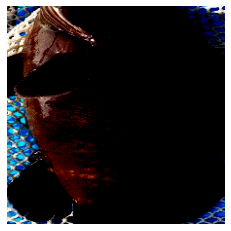

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: tensor([1, 1, 0, 0]), y.shape: torch.Size([4])
torch.Size([4, 3, 224, 224])


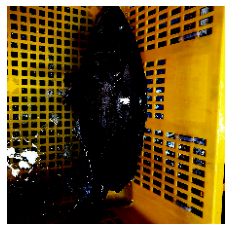

In [ ]:
import os
import torch
import albumentations as A
from PIL import Image
from glob import glob
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class OceanDataset(Dataset):
    
    def __init__(self, args, transform, dataset, mode='train'):
        super().__init__()
        self.args = args
        self.transform = transform
        self.dataset = np.array(dataset['path'].values)
        self.y = np.array(dataset['label'].values, dtype=int)
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img = np.array(Image.open(self.dataset[index]))[:,:,:3]
            
        if self.transform:
            img = self.transform(image=img)['image']
        
        if self.mode == 'train':
            y = self.y[index]
            return img, y
        
        return img


def get_transform(args):
    train_transform = A.Compose([
        A.Resize(height=350, width=350),
        A.OneOf([
            A.CenterCrop(config.img_height, config.img_width),
            # A.RandomCrop(args['img_size'],args['img_size'])
        ],p=1),
        
        A.RGBShift(r_shift_limit=15, g_shift_limit=15,b_shift_limit=15,p=0.3),
        A.Blur(blur_limit=3, p=0.3),
        A.Affine(translate_px=30, shear=30, p=0.5),
        A.Rotate(limit=25, p=0.3),
        A.HorizontalFlip(),
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ToTensorV2(),
    ])
    
    test_transform = A.Compose([
        A.Resize(height=config.img_height, width=config.img_width),
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ToTensorV2(),
    ])
    return {
        'train': train_transform,
        'test': test_transform
    }

    
def get_loader(args, x_train, x_valid):
    train_transform = get_transform(config)['train']
    train_dataset = OceanDataset(config, train_transform, x_train)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=config.num_workers)
    
    val_transform = get_transform(config)['test']
    val_dataset = OceanDataset(config, val_transform, x_valid)
    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=config.batch_size,
                            shuffle=False,
                            num_workers=config.num_workers)
    
    return {
        'train':train_loader, 
        'valid':val_loader
    }


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    x_train, x_valid = train_test_split(train, 
                                        test_size=0.2, 
                                        shuffle=config.shuffle, 
                                        random_state=config.random_state, 
                                        stratify=train['label'])
    
    train_loader = get_loader(config, x_train, x_valid)['train']
    valid_loader = get_loader(config, x_train, x_valid)['valid']
    
    # train loader test
    for (img, y) in train_loader:
        print(f"y: {y}, y.shape: {y.shape}")
        print(f"y: {y}")
        print(img.shape)
        plt.imshow(img[0].permute(1,2,0))
        plt.axis('off')
        plt.show()
        
        break
    
    # valid loader test
    for (img, y) in valid_loader:
        print(f"y: {y}, y.shape: {y.shape}")
        print(img.shape)
        plt.imshow(img[0].permute(1,2,0))
        plt.axis('off')
        plt.show()
        break

In [ ]:
import warnings
warnings.filterwarnings('ignore')


from torch import nn
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


skf = StratifiedKFold(n_splits=config.n_splits, 
                      shuffle=config.shuffle, 
                      random_state=config.random_state)

for fold_idx,(train_idx, valid_idx) in enumerate(
    skf.split(train, train['label'])
):
    best_loss = np.Inf
    cnt = 0
    
    print(f"================== fold={fold_idx+1} start!!! ==================")
    x_train = train.iloc[train_idx]
    x_valid = train.iloc[valid_idx]
    train_loader = get_loader(config, x_train, x_valid)['train']
    valid_loader = get_loader(config, x_train, x_valid)['valid']
    model_name = f'efficientnet-b{config.num_efficientnet}'
    model = EfficientNet.from_pretrained(model_name, num_classes=2)

    model.to(config.cuda)
    optimizer = torch.optim.AdamW(model.parameters(), config.lr)
    scaler = torch.cuda.amp.GradScaler()
    crit = torch.nn.CrossEntropyLoss()

    for epoch in range(config.epochs):
        print(f"------------- epoch={epoch+1} start!!! -------------")

        ######################################################
        # training loop
        ######################################################
        model.train()
        total_train_loss = []
        for idx, (img, y) in enumerate(tqdm(train_loader)):
            model.train()

            img = img.to(config.cuda)
            y = y.to(config.cuda)
            
            with torch.cuda.amp.autocast():
                y_pred = model(img)
                train_loss_val = crit(y_pred, y.long())
            
            optimizer.zero_grad()
            scaler.scale(train_loss_val).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss.append(train_loss_val.cpu().detach().numpy())

        ######################################################
        # evaluation loop
        ######################################################
        model.eval()
        total_val_loss = []    
        for (img, y) in tqdm(valid_loader):
            img = img.to(config.cuda)
            y = y.to(config.cuda)
            y_pred = model(img)
            eval_loss_val = crit(y_pred, y.long())
            total_val_loss.append(eval_loss_val.cpu().detach().numpy())
            
        print(f"[{epoch+1}/{config.epochs}] | train_loss = {np.mean(total_train_loss)} | val_loss={np.mean(total_val_loss)}")


        ######################################################
        # early stopping loop
        ######################################################
        if best_loss > np.mean(total_val_loss):
            best_loss = np.mean(total_val_loss)
            print(f"best_loss update!! | best_loss={best_loss}")
            torch.save(model.state_dict(),f'./{fold_idx}_{model_name}.pth')
            cnt = 0
        else:
            cnt += 1
            print(f"Don't improve loss [{cnt}/{config.patient}] | best_loss={best_loss} | val_loss={np.mean(total_val_loss)}")

        if cnt == config.patient:
            print(f"patient={cnt}...")
            print(f"val_loss={np.mean(total_val_loss)} | best_loss={best_loss}")
            break

    ######################################################
    # F1-score,precision, Recall, Accuracy 확인
    ######################################################
    f1, accuracy, recall, precision = 0, 0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for (img, y) in valid_loader:
            img = img.to(config.cuda)
            y = y.to(config.cuda)

            outputs = model(img)
            _, predicted = torch.max(outputs.data, 1)
            y_true += y.cpu().detach().numpy().tolist()
            y_pred += predicted.cpu().detach().numpy().tolist()

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f'fold{fold_idx} => f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, acc: {accuracy:.4f}')

    print(f"========================================================================\n")
    np.save(f'fold{fold_idx}_y_true.npy', np.array(y_true))
    np.save(f'fold{fold_idx}_y_pred.npy', np.array(y_pred))

================== fold=1 start!!! ==================
Loaded pretrained weights for efficientnet-b7
------------- epoch=1 start!!! -------------


 94%|█████████▍| 60/64 [00:34<00:02,  1.72it/s]


KeyboardInterrupt: ignored

In [ ]:
# b0 기준
# 0.5064893960952759 original
# 0.3883173167705536 horizontal, 
# 0.32820421457290656 horizontal, rotate
# 0.2596862018108368 horizontal, rotate, blur
# 0.19514910876750946 horizontal, rotate, blur, Affine, RGB shift
# 0.19514910876750946 horizontal, rotate, Affine, Crop

[[26  6]
 [ 4 28]]
[[26  6]
 [ 3 29]]
[[31  1]
 [ 4 28]]
[[29  3]
 [ 3 29]]
[[27  5]
 [ 3 29]]


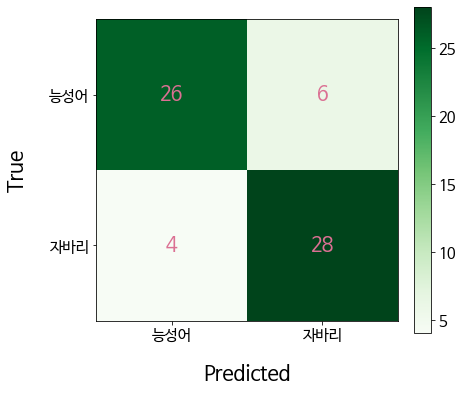

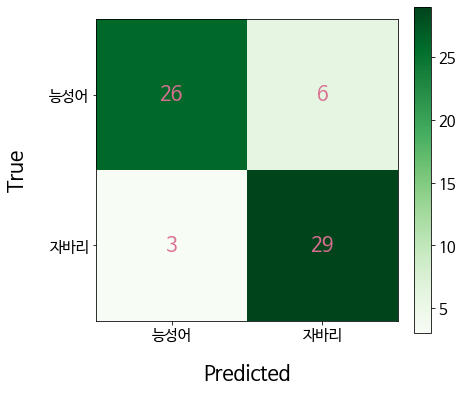

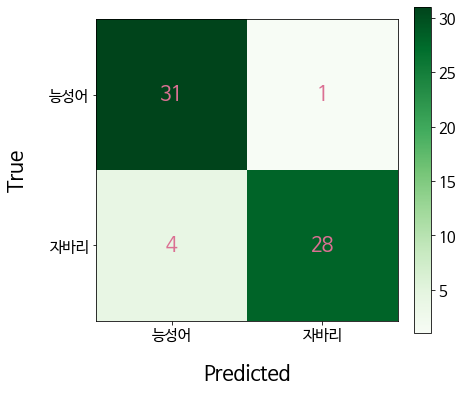

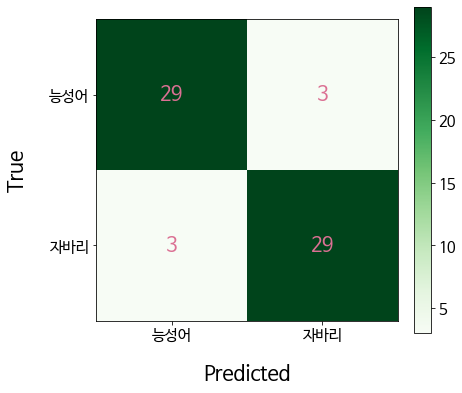

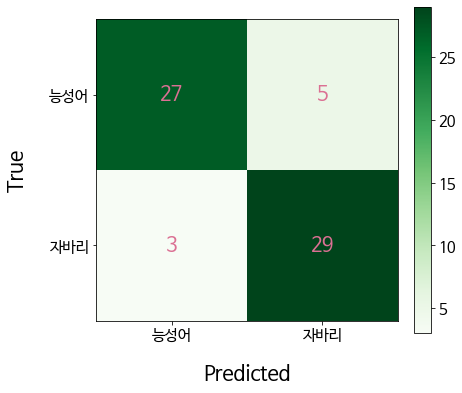

In [ ]:
for fold_id in range(5):
  y_true = np.load(f'fold{fold_id}_y_true.npy')
  y_pred = np.load(f'fold{fold_id}_y_pred.npy')
  plt.rcParams['font.family'] = 'NanumGothic'
  plt.rcParams['font.family'] = 'Malgun Gothic'
  plt.rcParams['font.size'] = 15

  plt.rc('font', family='NanumBarunGothic') 

  conf_matrix = confusion_matrix(y_true, y_pred)
  print(conf_matrix)
  # title = '2-class Confusion matrix'
  cmap=cmap=plt.cm.Greens
  plt.figure(figsize=(6, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
  # plt.title(title, size=12)
  plt.colorbar(fraction=0.05, pad=0.05)
  tick_marks = np.arange(2, 2)
  plt.xticks(np.arange(2), ('능성어', '자바리'))
  plt.yticks(np.arange(2), ('능성어', '자바리'))
  plt.ylabel('True', fontsize=20, labelpad=20)
  plt.xlabel('Predicted', fontsize=20, labelpad=20)


# [[26  6]
#  [ 4 28]]
# [[26  6]
#  [ 3 29]]
# [[31  1]
#  [ 4 28]]
# [[29  3]
#  [ 3 29]]
# [[27  5]
#  [ 3 29]]
  fmt = 'd' 
  thresh = 1
  for i in range(2):
      for j in range(2):
          plt.text(j, i, format(conf_matrix[i][j], fmt),color='palevioletred',
                  fontsize=20,
                  ha="center", va="center")

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
# plt.style.use('matplotlib')
plt.style.use("default")
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fold_id=3
y_true = np.load(f'fold{fold_id}_y_true.npy')
y_pred = np.load(f'fold{fold_id}_y_pred.npy')

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_true, y_pred, pos_label=1)

auc_score = roc_auc_score(y_true, y_pred)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_pred))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=f'ROC curve(area={auc_score:.4f})')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
# plt.title('2-class ROC curve')
# x label
plt.xlabel('False Positive Rate', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# y label
plt.ylabel('True Positive rate', fontsize=20, labelpad=20)

plt.legend(loc='lower right',  fontsize=15)
plt.savefig('ROC',dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar([1,2,3,4,5], [92, 94, 87, 88, 91])
plt.xlabel('K-Fold ID',fontsize=30, labelpad=20)
plt.ylabel('Accuracy',fontsize=30, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 어떤 이미지를 잘 구분하지 못하는지 계산
- 각 fold에서 가장 안좋은 정확도를 가지는 or recall이 가장 낮은 모델을 불러와서 실험

In [ ]:
x_train, x_valid = train_test_split(train, 
                                    test_size=0.2, 
                                    shuffle=config.shuffle, 
                                    random_state=config.random_state, 
                                    stratify=train['label'])

train_loader = get_loader(config, x_train, x_valid)['train']
valid_loader = get_loader(config, x_train, x_valid)['valid']

In [ ]:
model = EfficientNet.from_pretrained(model_name, num_classes=2)
model.load_state_dict(torch.load('/content/2_efficientnet-b7.pth'))
model.to(config.cuda)

f1, accuracy, recall, precision = 0, 0, 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    model.eval()
    for batch_id, (img, y) in enumerate(valid_loader):

        for i in range(config.batch_size):
            # img_s = img[i] * 256
            # img_s = img_s.clip(0, 255)
            plt.imshow(img[i].permute(1,2,0))
            plt.axis('off')
            plt.savefig(f'valid/{batch_id}_{i}',dpi=300)
        img = img.to(config.cuda)
        y = y.to(config.cuda)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        y_true += y.cpu().detach().numpy().tolist()
        y_pred += predicted.cpu().detach().numpy().tolist()

In [ ]:
print('잘못 분류한 이미지')
for i in range(len(y_true)):
  if y_pred[i] != y_true[i]:
    print(f'{i//config.batch_size}_{i%config.batch_size} ')

# 0: 능성어, 1: 자바리
# for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
#   if idx % config.batch_size == 0:
#     print()
#   print(f'정답: {true_label}, 예측: {pred_label} | ')

print(f'정답 레이블 : {y_true}')
print(f'예측 레이블 : {y_pred}')

In [ ]:
!zip -r /content/valid.zip /content/valid